In [1]:
import sqlite3
import pandas as pd
import requests
from bs4 import BeautifulSoup
import os
from selenium import webdriver
import time
import pickle
import numpy as np
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
  


### Web Scraping and Dataframe Creation

In [2]:
# Create a SQL connection to SQLite database
# Pulling all wildfire occurrence data for CA 
con = sqlite3.connect("Data/FPA_FOD_20210617.sqlite")
ca_fire_data = pd.read_sql_query('SELECT * FROM Fires WHERE STATE="CA"', con)

con.close()



In [3]:
ca_fire_data.head()
ca_fire_data.shape


(235229, 37)

In [4]:
ca_fire_data.columns


Index(['FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_PLUS_INCIDENT_JOIN_ID', 'ICS_209_PLUS_COMPLEX_JOIN_ID',
       'MTBS_ID', 'MTBS_FIRE_NAME', 'COMPLEX_NAME', 'FIRE_YEAR',
       'DISCOVERY_DATE', 'DISCOVERY_DOY', 'DISCOVERY_TIME',
       'NWCG_CAUSE_CLASSIFICATION', 'NWCG_GENERAL_CAUSE',
       'NWCG_CAUSE_AGE_CATEGORY', 'CONT_DATE', 'CONT_DOY', 'CONT_TIME',
       'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE', 'OWNER_DESCR',
       'STATE', 'COUNTY', 'FIPS_CODE', 'FIPS_NAME'],
      dtype='object')

In [5]:
ca_fire_data = ca_fire_data.drop(columns=["FOD_ID", "FPA_ID", 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM', 'NWCG_REPORTING_AGENCY', 
        'NWCG_REPORTING_UNIT_ID', 'NWCG_REPORTING_UNIT_NAME','SOURCE_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT','SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
        'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME','ICS_209_PLUS_INCIDENT_JOIN_ID', 'ICS_209_PLUS_COMPLEX_JOIN_ID',
        'MTBS_ID', 'MTBS_FIRE_NAME', 'COMPLEX_NAME','DISCOVERY_DOY','NWCG_CAUSE_AGE_CATEGORY', 'CONT_DOY', 'FIRE_SIZE_CLASS', 'OWNER_DESCR','STATE','COUNTY','FIPS_CODE','FIPS_NAME'])

In [6]:
ca_fire_data['LAT_LONG'] = ca_fire_data['LATITUDE'].astype(str)+','+ca_fire_data['LONGITUDE'].astype(str)



In [7]:
ca_fire_data=ca_fire_data.dropna()


In [8]:
ca_fire_data.shape



(130687, 11)

In [9]:
#Filtering data for last 1 year
ca_fire_data=ca_fire_data[ca_fire_data['FIRE_YEAR']>2017].reset_index(drop=True)



In [10]:
ca_fire_data.shape



(5566, 11)

In [11]:
ca_fire_data.head()


,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_TIME,NWCG_CAUSE_CLASSIFICATION,NWCG_GENERAL_CAUSE,CONT_DATE,CONT_TIME,FIRE_SIZE,LATITUDE,LONGITUDE,LAT_LONG
0,2018,7/1/2018 0:00,1400.0,Human,Missing data/not specified/undetermined,7/1/2018 0:00,1800.0,0.07,39.022500,-120.303611,"39.0225,-120.3036111"
1,2018,7/13/2018 0:00,755.0,Human,Equipment and vehicle use,7/14/2018 0:00,1800.0,0.50,38.715556,-120.398611,"38.71555556,-120.3986111"
2,2018,6/4/2018 0:00,1700.0,Human,Recreation and ceremony,6/4/2018 0:00,1919.0,0.10,38.718333,-120.512778,"38.71833333,-120.5127778"
3,2018,6/4/2018 0:00,334.0,Human,Recreation and ceremony,6/4/2018 0:00,1644.0,0.10,39.005833,-120.273889,"39.00583333,-120.2738889"
4,2018,1/15/2018 0:00,1530.0,Human,Debris and open burning,1/16/2018 0:00,1500.0,0.25,38.719444,-120.363333,"38.71944444,-120.3633333"


In [12]:
#Check if pickle file already exists
try:
    weather_data = pickle.load(open("weatherdata.pkl", "rb"))
except (OSError, IOError) as e:
    weather_data=[]
    weather_data.append(['LAT_LONG', 'WEATHER_DATE', 'TEMP_MAX', 'TEMP_MIN', 'TEMP_AVG', 'DEW', 'HUMIDITY', 'PRECIP', 'WIND_SPEED', 'WIND_DIR', 'SEA_LEVEL_PRESSURE','CLOUD_COVER','VISIBILITY'])


    #Web Scraping 

    BASE_URL = 'https://www.visualcrossing.com/weather/weather-data-services/'
    url=""

    for idx, row in ca_fire_data.iterrows():
        loc=row.LAT_LONG
        #Setting date to date-1 to scrape data for the day before Fire Discovery:
        date=pd.to_datetime(row['DISCOVERY_DATE']) - timedelta(1)
        date=datetime.strftime(date, '%Y-%m-%d')

        url=BASE_URL+loc+'/us/'+date+'/'+date

        chromedriver = "/Applications/chromedriver"
        os.environ["webdriver.chrome.driver"] = \
        chromedriver
        driver = webdriver.Chrome(chromedriver)
        driver.get(url)
        time.sleep(3)

        driver.find_element('xpath','//*[@id="tutorialModel"]/div/div/div[3]/button').click()
        time.sleep(2)

        driver.find_element('xpath', '//*[@id="errorModal"]/div/div/div[2]/div[2]/button[1]').click()
        time.sleep(2)

        driver.find_element('xpath','//*[@id="queryApp"]/div/div[4]/div[4]/div/button[5]').click()
        time.sleep(2)

        html = driver.page_source
        soup = BeautifulSoup(html)

        table=soup.find("table",class_="table table-striped fs-xs")

        row=[]
        for cell in table.tbody.tr.find_all('td'):    
            # Find all data for each column
            row.append(str(cell.renderContents().strip(),'utf-8'))

        row=row[0:5]+row[8:11]+row[17:22]        
        weather_data.append(row)
        #driver.close()
        
        

In [13]:
weather_df = pd.DataFrame(weather_data, columns=weather_data[0])
weather_df.drop(index=weather_df.index[0], axis=0, inplace=True)
weather_df = weather_df.reset_index(drop=True)


In [14]:
ca_fire_df = ca_fire_data.iloc[:3831,:]



In [15]:
weather_df.shape



(3830, 13)

In [16]:
ca_fire_df.tail()



,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_TIME,NWCG_CAUSE_CLASSIFICATION,NWCG_GENERAL_CAUSE,CONT_DATE,CONT_TIME,FIRE_SIZE,LATITUDE,LONGITUDE,LAT_LONG
3826,2018,10/29/2018 0:00,1722.0,Human,Missing data/not specified/undetermined,10/29/2018 0:00,1858.0,0.25,37.083579,-120.437017,"37.083579,-120.437017"
3827,2018,10/30/2018 0:00,1227.0,Human,Missing data/not specified/undetermined,10/30/2018 0:00,1244.0,0.25,39.126180,-122.862709,"39.12618,-122.862709"
3828,2018,10/31/2018 0:00,21.0,Human,Missing data/not specified/undetermined,10/31/2018 0:00,50.0,1.80,37.517233,-121.240250,"37.517233,-121.24025"
3829,2018,10/31/2018 0:00,8.0,Human,Missing data/not specified/undetermined,10/31/2018 0:00,56.0,1.00,33.991816,-117.475417,"33.991816,-117.475417"
3830,2018,10/31/2018 0:00,1151.0,Human,Missing data/not specified/undetermined,10/31/2018 0:00,1242.0,0.12,39.145621,-121.043757,"39.145621,-121.043757"


In [17]:
combined_df = pd.merge(ca_fire_df, weather_df, on='LAT_LONG', how='left')
combined_df = combined_df.drop(columns=['FIRE_YEAR','DISCOVERY_TIME', 'NWCG_GENERAL_CAUSE','CONT_TIME'])
combined_df = combined_df.drop_duplicates(subset=['LAT_LONG','DISCOVERY_DATE']).reset_index(drop=True)


In [18]:
combined_df.head()



,DISCOVERY_DATE,NWCG_CAUSE_CLASSIFICATION,CONT_DATE,FIRE_SIZE,LATITUDE,LONGITUDE,LAT_LONG,WEATHER_DATE,TEMP_MAX,TEMP_MIN,TEMP_AVG,DEW,HUMIDITY,PRECIP,WIND_SPEED,WIND_DIR,SEA_LEVEL_PRESSURE,CLOUD_COVER,VISIBILITY
0,7/1/2018 0:00,Human,7/1/2018 0:00,0.07,39.022500,-120.303611,"39.0225,-120.3036111",2018-06-30,78.9,47.8,64.7,37,39.97,0,11.1,187.1,1016.2,0,9.9
1,7/13/2018 0:00,Human,7/14/2018 0:00,0.50,38.715556,-120.398611,"38.71555556,-120.3986111",2018-07-12,89.8,62.8,76.5,46.7,36.68,0,10.9,161.5,1017.5,1.3,9.9
2,6/4/2018 0:00,Human,6/4/2018 0:00,0.10,38.718333,-120.512778,"38.71833333,-120.5127778",2018-06-03,86,64.9,75.8,44.7,34.67,0,8.8,168.8,1016.3,0,9.9
3,6/4/2018 0:00,Human,6/4/2018 0:00,0.10,39.005833,-120.273889,"39.00583333,-120.2738889",2018-06-03,79.4,45.2,63,38.9,45.65,0,12.8,161,1016.2,0,9.9
4,1/15/2018 0:00,Human,1/16/2018 0:00,0.25,38.719444,-120.363333,"38.71944444,-120.3633333",2018-01-14,57.6,38.7,46.3,30.9,55.66,0,5.1,124.7,1027.2,1.9,9.8


In [19]:
combined_df[['TEMP_MAX','TEMP_MIN','TEMP_AVG','DEW','HUMIDITY','PRECIP','WIND_SPEED','WIND_DIR','SEA_LEVEL_PRESSURE','CLOUD_COVER','VISIBILITY']]=combined_df[['TEMP_MAX','TEMP_MIN','TEMP_AVG','DEW','HUMIDITY','PRECIP','WIND_SPEED','WIND_DIR','SEA_LEVEL_PRESSURE','CLOUD_COVER','VISIBILITY']].apply(pd.to_numeric)
combined_df = combined_df.dropna()


In [20]:
combined_df.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 3657 entries, 0 to 3811
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   DISCOVERY_DATE             3657 non-null   object 
 1   NWCG_CAUSE_CLASSIFICATION  3657 non-null   object 
 2   CONT_DATE                  3657 non-null   object 
 3   FIRE_SIZE                  3657 non-null   float64
 4   LATITUDE                   3657 non-null   float64
 5   LONGITUDE                  3657 non-null   float64
 6   LAT_LONG                   3657 non-null   object 
 7   WEATHER_DATE               3657 non-null   object 
 8   TEMP_MAX                   3657 non-null   float64
 9   TEMP_MIN                   3657 non-null   float64
 10  TEMP_AVG                   3657 non-null   float64
 11  DEW                        3657 non-null   float64
 12  HUMIDITY                   3657 non-null   float64
 13  PRECIP                     3657 non-null   float

### EDA and Feature Engineering



In [21]:
#Convert Category column to numerical :
# Shortcut _ Use pd.Category/factorize

for row in combined_df.itertuples():
    if row.NWCG_CAUSE_CLASSIFICATION  == 'Human':
        combined_df.loc[row.Index, "CAUSE"]=1
    elif row.NWCG_CAUSE_CLASSIFICATION =='Natural':
        combined_df.loc[row.Index, "CAUSE"]=2
    else:
        combined_df.loc[row.Index,"CAUSE"]=3


In [22]:
# Drop extra columsn (non-numerical)

drop_columns = ['DISCOVERY_DATE', 'NWCG_CAUSE_CLASSIFICATION','CONT_DATE', 'LAT_LONG','WEATHER_DATE']
data_df=combined_df.drop(drop_columns, axis=1)



In [23]:
# Function for spliting data into train, validation, test data

def split_data(all_df):
    df_rem, df_test = train_test_split(all_df, test_size=0.20, random_state=3)
    df_train, df_val = train_test_split(all_df, test_size=0.25, random_state=8)

    return df_train,df_val,df_test



In [24]:
#Funcations for fitting and scoring train/validation data

def train_model(train_df,m):
    y_train=train_df[['FIRE_SIZE']]
    X_train=train_df.drop('FIRE_SIZE', axis=1)

    m.fit(X_train, y_train)
    score=m.score(X_train,y_train)
    print('Train score:', score)
    
    return m, score

def val_model(val_df,m):
    y_val=val_df[['FIRE_SIZE']]
    X_val=val_df.drop('FIRE_SIZE', axis=1)
    v_score = m.score(X_val,y_val)
    print('Val score:', v_score )
    return v_score



In [25]:
#Initial Model (Baseline):

df_train, df_val, df_test = split_data(data_df)
model = LinearRegression()

fit_model, train_score = train_model(df_train, model)
val_score = val_model(df_val, fit_model)

r2_scores = [['Model', 'Train_Score', 'Val_Score', 'Test_Score']]
r2_scores.append(['Baseline Model', train_score, val_score, '-'])



Train score: 0.0066973648088055615
Val score: -0.0022044748479403964


In [26]:
data_df.describe()


,FIRE_SIZE,LATITUDE,LONGITUDE,TEMP_MAX,TEMP_MIN,TEMP_AVG,DEW,HUMIDITY,PRECIP,WIND_SPEED,WIND_DIR,SEA_LEVEL_PRESSURE,CLOUD_COVER,VISIBILITY,CAUSE
count,3657.000000,3657.000000,3657.000000,3657.000000,3657.000000,3657.000000,3657.000000,3657.000000,3657.000000,3657.000000,3657.000000,3657.000000,3657.000000,3657.000000,3657.000000
mean,388.965980,37.631153,-120.282975,82.307684,54.778944,68.083566,44.592125,49.647640,0.009182,12.381515,206.949193,1014.009653,15.385152,9.364479,1.091058
std,8795.820434,2.518538,2.104824,13.608680,10.714373,11.710702,10.670136,17.972264,0.062793,4.347321,62.727377,4.454954,22.126061,1.278440,0.293380
min,0.010000,32.555828,-124.329500,37.500000,5.700000,28.800000,-5.900000,7.430000,0.000000,0.100000,5.000000,979.100000,0.000000,1.200000,1.000000
25%,0.100000,35.729095,-121.688535,72.400000,48.800000,60.000000,39.700000,36.780000,0.000000,9.300000,160.300000,1011.200000,0.100000,9.300000,1.000000
50%,0.100000,37.648445,-120.614556,83.300000,55.000000,68.200000,47.100000,47.200000,0.000000,11.800000,202.600000,1013.500000,4.800000,9.900000,1.000000
75%,1.000000,39.523483,-118.983889,93.000000,61.500000,76.600000,51.800000,61.650000,0.000000,14.900000,254.700000,1016.600000,22.100000,9.900000,1.000000
max,410203.000000,42.002117,-114.386400,119.000000,97.100000,105.200000,69.400000,98.200000,1.410000,38.500000,332.300000,1030.900000,100.000000,20.100000,3.000000


In [27]:
y_stats=data_df[['FIRE_SIZE']]
X_stats=data_df.drop('FIRE_SIZE', axis=1)

X_stats = sm.add_constant(X_stats)
stats_model = sm.OLS(y_stats,X_stats).fit()

stats_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              FIRE_SIZE   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9907
Date:                Wed, 10 Aug 2022   Prob (F-statistic):              0.460
Time:                        15:41:35   Log-Likelihood:                -38395.
No. Observations:                3657   AIC:                         7.682e+04
Df Residuals:                    3642   BIC:                         7.691e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -3.029e+04   4.45e+04     -0.681      0.496   -1.17e+05    5.69e+04
LATITUDE            -152.8464    146.685     -1.042      0.297    -440.440     134.747
LONGITUDE           -362.1123    175.902     -2.059      0.040    -706.988     -17.237
TEMP_MAX              29.7761     61.357      0.485      0.627     -90.521     150.073
TEMP_MIN             -18.5941     61.980     -0.300      0.764    -140.113     102.925
TEMP_AVG              17.8475    118.482      0.151      0.880    -214.451     250.146
DEW                  -13.1248     56.464     -0.232      0.816    -123.829      97.579
HUMIDITY              -3.8237     37.098     -0.103      0.918     -76.558      68.910
PRECIP               428.6397   2456.670      0.174      0.861   -4387.946    5245.226
WIND_SPEED           -13.4792     37.380     -0.361      0.718     -86.767      59.808
WIND_DIR              -1.8674      2.620     -0.713      0.476      -7.005       3.270
SEA_LEVEL_PRESSURE    -7.8254     41.228     -0.190      0.849     -88.657      73.006
CLOUD_COVER            2.1035      9.296      0.226      0.821     -16.123      20.330
VISIBILITY           -32.2027    132.957     -0.242      0.809    -292.880     228.475
CAUSE               -227.6666    557.723     -0.408      0.683   -1321.147     865.814
==============================================================================
Omnibus:                    10153.920   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        316930510.407
Skew:                          35.019   Prob(JB):                         0.00
Kurtosis:                    1443.497   Cond. No.                     3.22e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.22e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

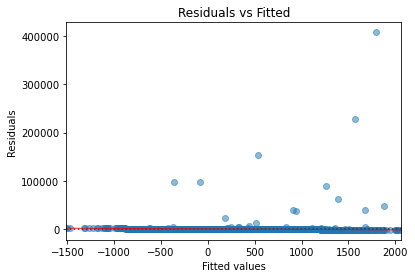

In [28]:
model_fitted_y = stats_model.fittedvalues

plt = sns.residplot(x=model_fitted_y, y='FIRE_SIZE', data=data_df, lowess=True, 
                     scatter_kws={'alpha': 0.5}, 
                     line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plt.set_title('Residuals vs Fitted')
plt.set_xlabel('Fitted values')
plt.set_ylabel('Residuals');



#### Residuals are heavily Y-AXIS UNBALANCED. This means that data is not normally distributed and there are outliers. This causes predictions to be too low (hence positive axis imbalance)




/Users/aanvigoel/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='FIRE_SIZE', ylabel='Density'>

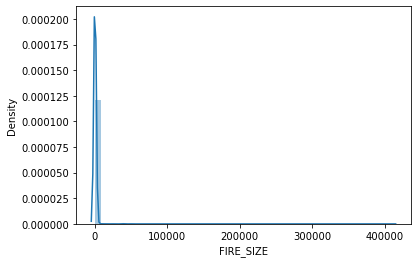

In [29]:
#FIRE_SIZE = The estimate of acres within the final perimeter of the fire.

sns.distplot(data_df['FIRE_SIZE'])


In [30]:
#Understanding data skewness
data_df.agg(['skew'])



,FIRE_SIZE,LATITUDE,LONGITUDE,TEMP_MAX,TEMP_MIN,TEMP_AVG,DEW,HUMIDITY,PRECIP,WIND_SPEED,WIND_DIR,SEA_LEVEL_PRESSURE,CLOUD_COVER,VISIBILITY,CAUSE
skew,35.204903,-0.190024,0.43162,-0.298382,-0.251725,-0.160159,-1.206296,0.314177,12.194452,0.856114,-0.012204,0.227697,1.801881,-2.070015,3.037591


### TRANSFORMING DEPENDENT VARIABLE:  FIRE_SIZE

/Users/aanvigoel/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/aanvigoel/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/aanvigoel/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-l

Text(0.5, 1.0, 'Boxcox')

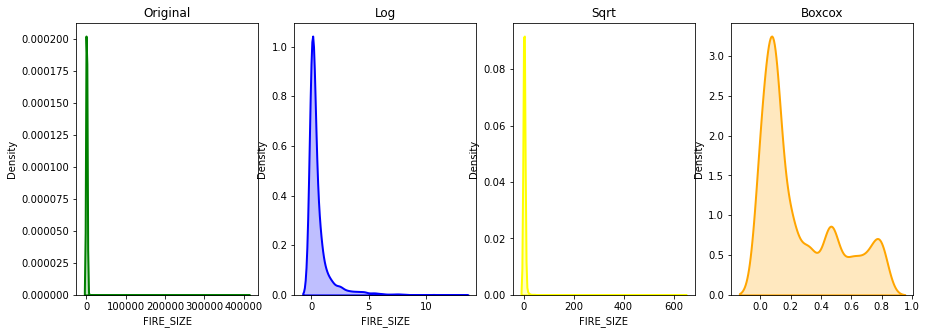

In [31]:
import matplotlib.pyplot as plt

y_log = np.log(data_df['FIRE_SIZE']+1)
y_sqrt = np.sqrt(data_df['FIRE_SIZE']+1)
y_boxcox, y_lambda = stats.boxcox(data_df['FIRE_SIZE']+1)

fig, ax = plt.subplots(1, 4)
fig.set_figheight(5)
fig.set_figwidth(15)

sns.distplot(data_df['FIRE_SIZE'], hist = False, kde = True,kde_kws = {'shade': True, 'linewidth': 2},
            color ="green", ax = ax[0]).set_title('Original')
 
sns.distplot(y_log, hist = False, kde = True,kde_kws = {'shade': True, 'linewidth': 2},
            color ="blue", ax = ax[1]).set_title('Log')

sns.distplot(y_sqrt, hist = False, kde = True,kde_kws = {'shade': True, 'linewidth': 2},
            color ="Yellow", ax = ax[2]).set_title('Sqrt')

sns.distplot(y_boxcox, hist = False, kde = True,kde_kws = {'shade': True, 'linewidth': 2},
            color ="Orange", ax = ax[3]).set_title('Boxcox')


In [32]:
data_df['FIRE_SIZE']=y_boxcox



In [33]:
data_df.agg(['skew'])



,FIRE_SIZE,LATITUDE,LONGITUDE,TEMP_MAX,TEMP_MIN,TEMP_AVG,DEW,HUMIDITY,PRECIP,WIND_SPEED,WIND_DIR,SEA_LEVEL_PRESSURE,CLOUD_COVER,VISIBILITY,CAUSE
skew,0.91412,-0.190024,0.43162,-0.298382,-0.251725,-0.160159,-1.206296,0.314177,12.194452,0.856114,-0.012204,0.227697,1.801881,-2.070015,3.037591


In [34]:
X_stats = sm.add_constant(data_df.drop('FIRE_SIZE',axis=1))
stats_model = sm.OLS(data_df['FIRE_SIZE'],X_stats).fit()

stats_model.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              FIRE_SIZE   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     8.816
Date:                Wed, 10 Aug 2022   Prob (F-statistic):           3.09e-19
Time:                        15:41:36   Log-Likelihood:                -107.38
No. Observations:                3657   AIC:                             244.8
Df Residuals:                    3642   BIC:                             337.8
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.2757      1.263     -1.010      0.312      -3.751       1.200
LATITUDE              -0.0140      0.004     -3.371      0.001      -0.022      -0.006
LONGITUDE             -0.0227      0.005     -4.541      0.000      -0.032      -0.013
TEMP_MAX               0.0034      0.002      1.963      0.050    3.63e-06       0.007
TEMP_MIN              -0.0026      0.002     -1.506      0.132      -0.006       0.001
TEMP_AVG              -0.0043      0.003     -1.267      0.205      -0.011       0.002
DEW                    0.0059      0.002      3.670      0.000       0.003       0.009
HUMIDITY              -0.0029      0.001     -2.799      0.005      -0.005      -0.001
PRECIP                -0.1531      0.070     -2.196      0.028      -0.290      -0.016
WIND_SPEED             0.0033      0.001      3.082      0.002       0.001       0.005
WIND_DIR           -4.272e-05   7.44e-05     -0.574      0.566      -0.000       0.000
SEA_LEVEL_PRESSURE    -0.0007      0.001     -0.619      0.536      -0.003       0.002
CLOUD_COVER            0.0003      0.000      1.295      0.196      -0.000       0.001
VISIBILITY             0.0057      0.004      1.513      0.130      -0.002       0.013
CAUSE                  0.0140      0.016      0.884      0.377      -0.017       0.045
==============================================================================
Omnibus:                      423.459   Durbin-Watson:                   1.790
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              491.261
Skew:                           0.858   Prob(JB):                    2.11e-107
Kurtosis:                       2.474   Cond. No.                     3.22e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.22e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

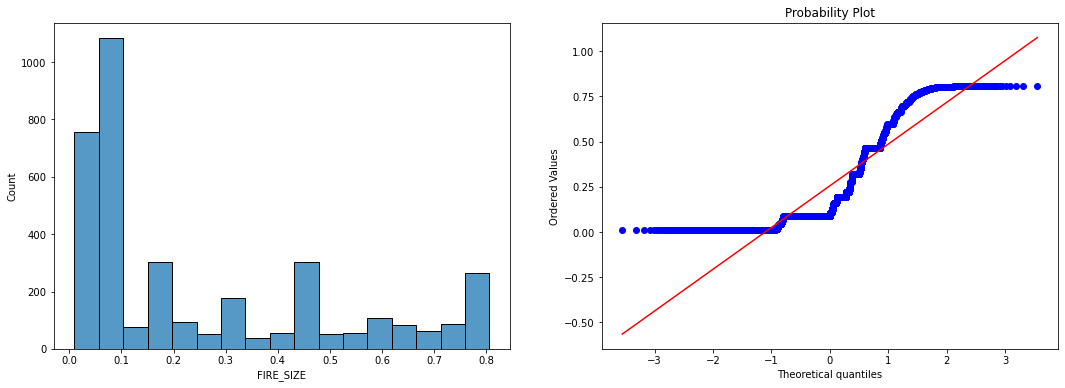

In [35]:
#Plotting QQ plots for FIRE SIZE:

fig , ax = plt.subplots(1,2, figsize=(18,6))
ax1 = sns.histplot(data=data_df, x='FIRE_SIZE', ax=ax[0]);
ax2 = stats.probplot(data_df.FIRE_SIZE, dist='norm', plot=plt)


#### FIRE_SIZE distribution has light tail ditribution

In [36]:
# Checking accuracy after transform: 

df_train, df_val, df_test = split_data(data_df)
model = LinearRegression()

fit_model, train_score = train_model(df_train, model)
val_score = val_model(df_val, model)

r2_scores.append(['Y Transformed Model', train_score, val_score, '-'])



Train score: 0.02618162178332617
Val score: 0.042815276855735496


### SIMPLIFYING DATASET: Drop Features with Multi-Collinearity and Low Significance (P-values)

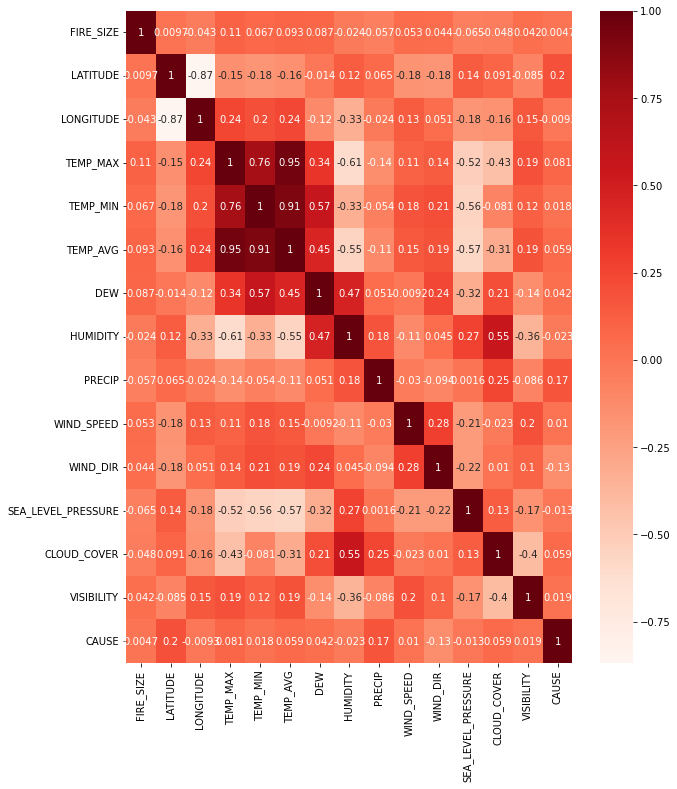

In [37]:
#data_df.corr()
plt.figure(figsize=(10,12)) 
corr=data_df.corr() 
sns.heatmap(corr, annot=True, cmap=plt.cm.Reds) 
plt.show()


In [38]:
#Dropping features causing Multi-collinearity:
data_df = data_df.drop(columns=['TEMP_AVG', 'TEMP_MIN'], axis=1)



In [39]:
# Checking accuracy after dropping Multi-collinear features: 

df_train, df_val, df_test = split_data(data_df)
model = LinearRegression()

fit_model, train_score = train_model(df_train, model)
val_score = val_model(df_val, fit_model)

r2_scores.append(['Simplified Model', train_score, val_score, '-'])



Train score: 0.024159147145892956
Val score: 0.02980341784462781


### SCALING FEATURES:

In [40]:
scaler = StandardScaler()
df_train, df_test = train_test_split(data_df, test_size=0.2,random_state=14)

X_train, y_train = df_train.drop('FIRE_SIZE', axis=1), df_train['FIRE_SIZE']
X_test, y_test = df_test.drop('FIRE_SIZE', axis=1), df_test['FIRE_SIZE']

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



In [41]:
model = LinearRegression()

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=3)

model.fit(X_tr, y_tr)
train_score = model.score(X_tr,y_tr)
val_score = model.score(X_val,y_val)

print('Scaled Train score:', train_score)
print('Scaled Val score:', val_score)


Scaled Train score: 0.029191983244985953
Scaled Val score: 0.01466605072602456


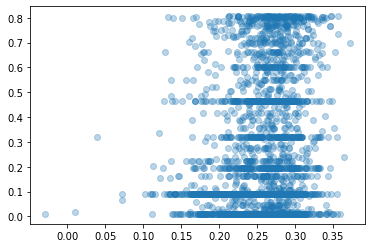

In [42]:
lin_model=LinearRegression()
lin_model.fit(X_train, y_train)

y_train_pred = lin_model.predict(X_train)
plt.scatter(y_train_pred, y_train, alpha=0.3)



In [43]:
y_pred = lin_model.predict(X_test)
test_score = r2_score(y_test, y_pred)
print("Scaled MSE:", mean_squared_error(y_test, y_pred))
print("Scaled Test Score:", test_score)

r2_scores.append(['Scaled Model', train_score, val_score, test_score])

Scaled MSE: 0.060783248043708014
Scaled Test Score: 0.0257003105909015


Text(0.5, 1.0, 'Residuals')

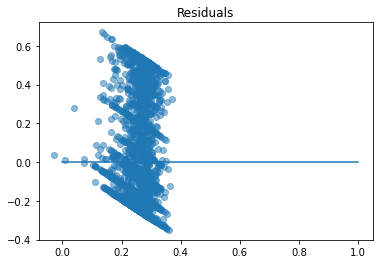

In [44]:
lin_residuals = y_train - y_train_pred
plt.scatter(y_train_pred, lin_residuals, alpha=0.5)
plt.plot([0,1],[0,0])
plt.title('Residuals')



In [45]:
pd.DataFrame(r2_scores, columns=r2_scores[0]).drop(0)

,Model,Train_Score,Val_Score,Test_Score
1,Baseline Model,0.006697,-0.002204,-
2,Y Transformed Model,0.026182,0.042815,-
3,Simplified Model,0.024159,0.029803,-
4,Scaled Model,0.029192,0.014666,0.0257


### REGULARIZATION: 

In [46]:
r2_model_scores=[['Model', 'Test_Score']]

In [47]:
kfold = KFold(n_splits = 5, shuffle=True, random_state=0)

def regularize_model(model, X, y, cv=5, **params):
    
    grid_CV = GridSearchCV(model, param_grid = params, cv=kfold, return_train_score=False)
    grid_CV.fit(X, y)
    
    return grid_CV



In [48]:
alphas = [0.0001,0.005,0.001,0.05,0.01,0.1,1,5,10]

lasso_model=regularize_model(Lasso(), X_train, y_train, cv=kfold, alpha= alphas)
ridge_model=regularize_model(Ridge(), X_train, y_train, cv=kfold, alpha= alphas)
elasticnet_model=regularize_model(ElasticNet(), X_train, y_train, cv=kfold, alpha= alphas)



In [49]:
y_pred = lasso_model.predict(X_test)
test_score = r2_score(y_test, y_pred)
print("Lasso Regression MSE:", mean_squared_error(y_test, y_pred))
print("Lasso Regression R2_score:", test_score,"\n")
r2_model_scores.append(['Lasso Model',test_score])

y_pred = ridge_model.predict(X_test)
test_score = r2_score(y_test, y_pred)
print("Ridge Regression MSE:", mean_squared_error(y_test, y_pred))
print("Ridge Regression R2_score:", test_score,"\n")
r2_model_scores.append(['Ridge Model',test_score])

y_pred = elasticnet_model.predict(X_test)
test_score = r2_score(y_test, y_pred)
print("ElasticNet Regression MSE:", mean_squared_error(y_test, y_pred))
print("ElasticNet Regression R2_score:", test_score)
r2_model_scores.append(['Elastic Net Model',test_score])



Lasso Regression MSE: 0.06072946656743875
Lasso Regression R2_score: 0.02656237830382502 

Ridge Regression MSE: 0.06076802326138162
Ridge Regression R2_score: 0.0259443498808265 

ElasticNet Regression MSE: 0.06073431926848269
ElasticNet Regression R2_score: 0.026484593959090752


### Polynomial Transformation

In [50]:
#Polynomial Transform 
poly = PolynomialFeatures()

y_train = df_train['FIRE_SIZE']
X_train = df_train.drop(['FIRE_SIZE'], axis=1)

X_poly_train = poly.fit_transform(X_train)

lin_poly = LinearRegression()
lin_poly.fit(X_poly_train, y_train) 
train_score = lin_poly.score(X_poly_train, y_train)

y_test = df_test['FIRE_SIZE']
X_poly_test = poly.transform(df_test.drop(['FIRE_SIZE'], axis=1))
y_pred = lin_poly.predict(X_poly_test)

test_score = r2_score(y_test, y_pred)
#print("Polynomial Train Score:", train_score)
print("Polynomial Test Score:", test_score)
r2_scores.append(['Polynomial Model', '-', '-', test_score])

Polynomial Test Score: 0.023275559545452795


In [51]:
alphas = [0.0001,0.005,0.001,0.05,0.01,0.1,1,5,10]

lasso_model_poly=regularize_model(Lasso(), X_poly_train, y_train, cv=kfold, alpha= alphas)
ridge_model_poly=regularize_model(Ridge(), X_poly_train, y_train, cv=kfold, alpha= alphas)
elasticnet_model_poly=regularize_model(ElasticNet(), X_poly_train, y_train, cv=kfold, alpha= alphas)


/Users/aanvigoel/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.945e+01, tolerance: 1.483e-02
  model = cd_fast.enet_coordinate_descent(
/Users/aanvigoel/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.083e+01, tolerance: 1.508e-02
  model = cd_fast.enet_coordinate_descent(
/Users/aanvigoel/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 

/Users/aanvigoel/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.112e+01, tolerance: 1.537e-02
  model = cd_fast.enet_coordinate_descent(
/Users/aanvigoel/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.024e+01, tolerance: 1.483e-02
  model = cd_fast.enet_coordinate_descent(
/Users/aanvigoel/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 

/Users/aanvigoel/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.248e+01, tolerance: 1.549e-02
  model = cd_fast.enet_coordinate_descent(
/Users/aanvigoel/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.911e+01, tolerance: 1.484e-02
  model = cd_fast.enet_coordinate_descent(
/Users/aanvigoel/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 

/Users/aanvigoel/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.419e+01, tolerance: 1.549e-02
  model = cd_fast.enet_coordinate_descent(
/Users/aanvigoel/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.328e+00, tolerance: 1.484e-02
  model = cd_fast.enet_coordinate_descent(
/Users/aanvigoel/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 

In [52]:
y_pred = lasso_model_poly.predict(X_poly_test)
test_score = r2_score(y_test, y_pred)
print("Lasso Regression MSE:", mean_squared_error(y_test, y_pred))
print("Lasso Regression R2_score:", test_score,"\n")
r2_model_scores.append(['Polynomial + Lasso Model', test_score])

y_pred = ridge_model_poly.predict(X_poly_test)
test_score = r2_score(y_test, y_pred)
print("Ridge Regression MSE:", mean_squared_error(y_test, y_pred))
print("Ridge Regression R2_score:", test_score,"\n")
r2_model_scores.append(['Polynomial + Ridge Model', test_score])

y_pred = elasticnet_model_poly.predict(X_poly_test)
test_score = r2_score(y_test, y_pred)
print("ElasticNet Regression MSE:", mean_squared_error(y_test, y_pred))
print("ElasticNet Regression R2_score:", test_score)
r2_model_scores.append(['Polynomial + Elastic Net Model', test_score])



Lasso Regression MSE: 0.060242974266654904
Lasso Regression R2_score: 0.034360403463862266 

Ridge Regression MSE: 0.059988397039276546
Ridge Regression R2_score: 0.03844104281020011 

ElasticNet Regression MSE: 0.06033154558261581
ElasticNet Regression R2_score: 0.03294068654499649


In [53]:
#Comparing R2 values:

pd.DataFrame(r2_model_scores, columns=r2_model_scores[0]).drop(0)


,Model,Test_Score
1,Lasso Model,0.026562
2,Ridge Model,0.025944
3,Elastic Net Model,0.026485
4,Polynomial + Lasso Model,0.03436
5,Polynomial + Ridge Model,0.038441
6,Polynomial + Elastic Net Model,0.032941


(-1.0, 1.0)

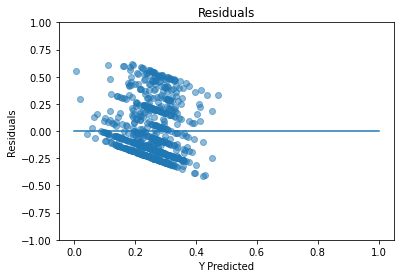

In [54]:
y_final_pred= ridge_model_poly.predict(X_poly_test)

final_residuals = y_test - y_final_pred

plt.scatter(y_final_pred, final_residuals, alpha=0.5)
plt.plot([0,1],[0,0])
plt.title('Residuals')
plt.xlabel('Y Predicted')
plt.ylabel('Residuals')
plt.ylim(-1,1)


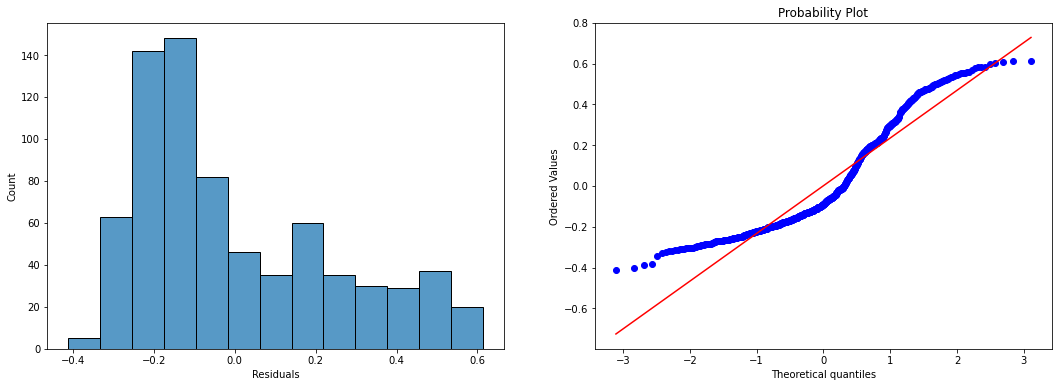

In [55]:
fig , ax = plt.subplots(1,2, figsize=(18,6))
ax1 = sns.histplot(final_residuals, ax=ax[0])
ax1.set_xlabel('Residuals')
ax2 = stats.probplot(final_residuals, dist='norm', plot=plt)


In [56]:
print('Evaluating Performance of Final Model:')
print(f'R2 score: {r2_score(y_test, y_final_pred): .2f}')
print(f'Mean absolute error: {mean_absolute_error(y_test, y_final_pred):.2f}')
print(f'Mean squared error: {mean_squared_error(y_test, y_final_pred):.2f}')
print(f'Root mean squared error: {np.sqrt(mean_squared_error(y_test, y_final_pred)):.2f} \n')


Evaluating Performance of Final Model:
R2 score:  0.04
Mean absolute error: 0.21
Mean squared error: 0.06
Root mean squared error: 0.24 

